# Variable Density Tesseroids test: Exponential density

## Determination of $D$ and $\delta$

On this notebook we will consider Tesseroids with exponential density function with the objective to determine the optimal pair of $D$ and $\delta$ at which the error of the numerical approximation of the gravity fields is under the 0.1% threshold while their computation is time efficient.

One way to do this is to explore values of $D$ and $\delta$ and compute the error of the numerical approximation by a simple grid search. Before performing it and getting empirical data, we can analyse the $(D, \delta)$ space and anticipate how the error of the computation and its effectiveness will be in certain regions.

On the first hand, we should make clear that for higher $D$ or lower $\delta$ the numerical error is lower or equal, because more discretizations of the tesseroids are expected.

On the second hand, we must notice that a higher $D$ will introduce more discretizations in all directions ($r$, $\phi$ and $\lambda$), but a lower $\delta$ will only subdivide the tesseroid in the $r$ direction. With this facts in mind, we can state that an increase of $D$ will likely produce a higher computation time than a decrease of $\delta$.

Finally, we want to point out that the $D$ and $\delta$ parameters we will obtain on this notebook are intended to be the default ones for every variable density tesseroid computation, including the linear density one tested in the `03-linear-density-test.ipynb` notebook. On those tests the density-based discretization was not applyied due to the nature of the linear density function and how the algorithm is built, so the numerical error is only controlled by the value of $D$ on that specific case. That's why the default value of $D$ that we will determine on this notebook can't be lower than the $D$ value obtained for the linear density case.

From these points we can divide the $(D, \delta)$ space in two: values with $D$ lower than $D_\text{linear}$, and values with $D$ greater or equal to $D_\text{linear}$. The $(D, \delta)$ pairs in the first group are not of our interest because are not elegible as default according to the previous paragraph.

Lets assume we keep $D = D_\text{linear}$ and explore values of $\delta$ on that profile. For large $\delta$ the numerical error will be high, but as we lower $\delta$ we will arrive at a certain value (that we will call $\delta_p$) at which the numerical error gets under the 0.1% threshold. For lower $\delta$ the error will also be under the threshold, but the computation won't be efficient because the discretizations will likely increase.

The region of the $(D, \delta)$ space with $D \ge D_\text{linear}$ can also be subvided in two: a subregion with $\delta$ greater than $\delta_p$ and another with $\delta$ lower or equal to $\delta_p$. On the later one we can ensure that the numerical error will always be under the threshold: a lower $\delta$ or a greater $D$ will produce more discretizations, lowering the error.
But for the former subregion, we don't specifically know whether the error will be above or below the threshold, but we can state that any point in that subregion will produce a higher computation time: a larger $\delta$ and a larger $D$ involves more discretizations than a lower $\delta$ and a lower $D$.

Therefore, the optimal $(D, \delta)$ pair is the one where $D = D_\text{linear}$ and $\delta = \delta_p$.

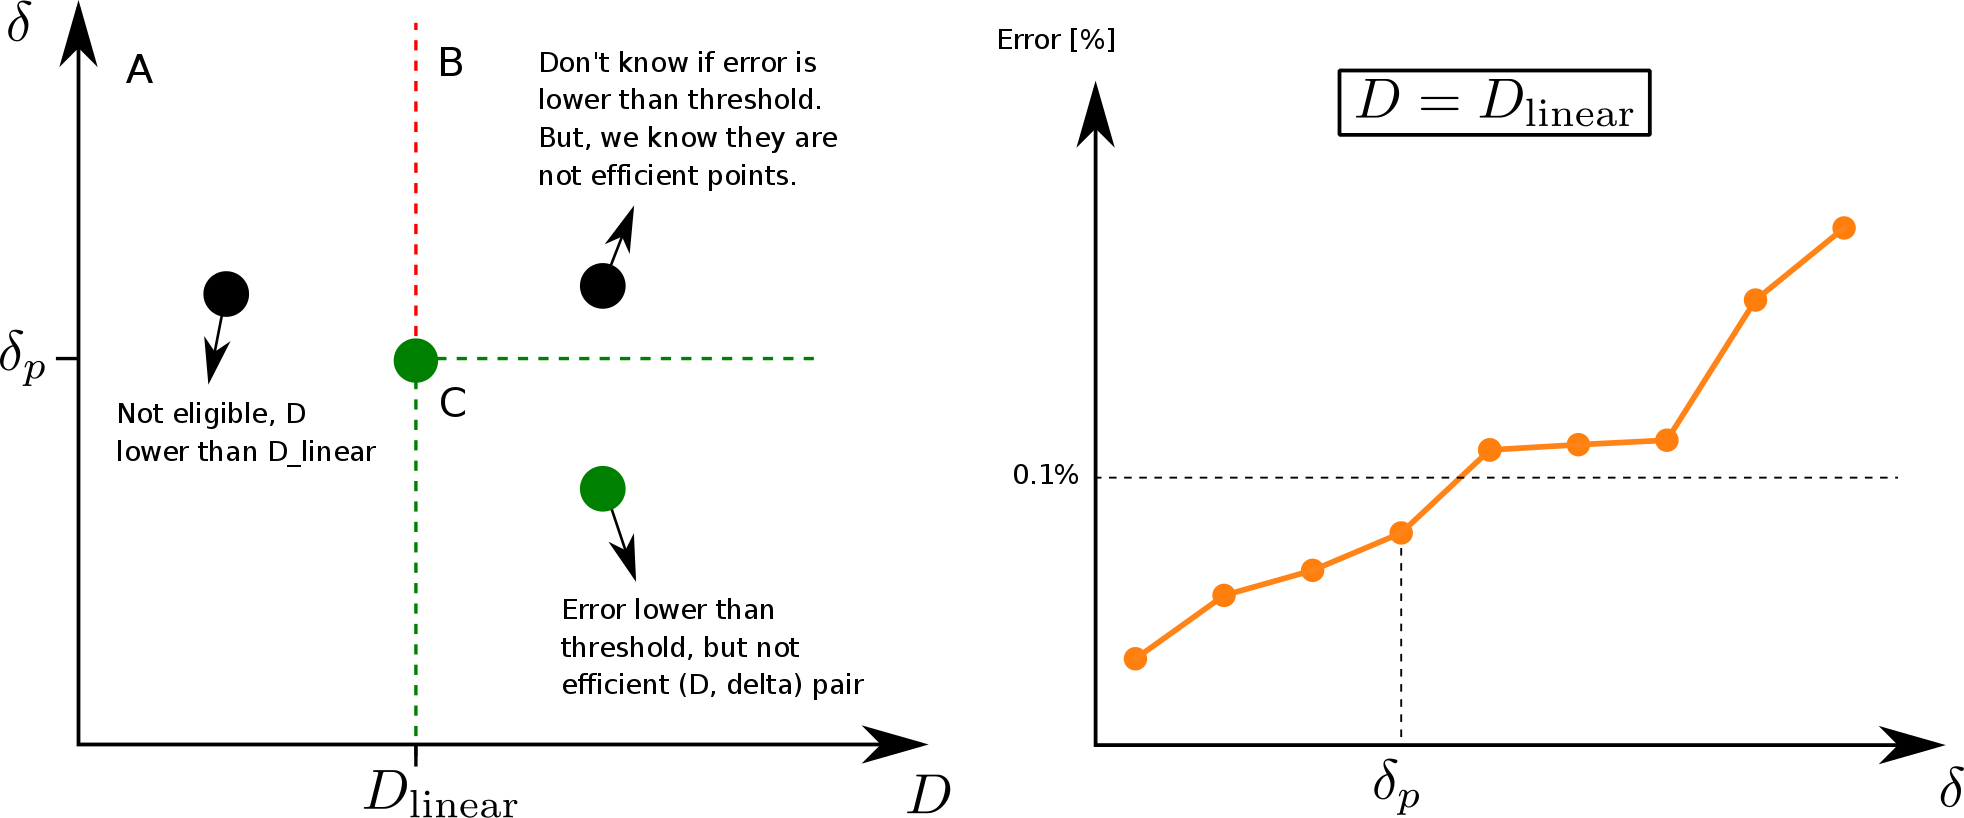

So in this notebook we will keep $D$ equal to the values obtained in the linear density notebook and explore values of $\delta$ in order to find the greatest one whose error is lower than the threshold. We will perform this determination for a thin and a thick spherical shell (1km and 35km of thickness, respectively) with different exponential functions.

## Determination of $\delta$: Thin Spherical Shell

** Import packages **

In [ ]:
from __future__ import division
import numpy as np
from fatiando.constants import G, MEAN_EARTH_RADIUS, SI2MGAL, SI2EOTVOS
from fatiando.mesher import Tesseroid, TesseroidMesh
from fatiando import gridder
import matplotlib.pyplot as plt
# This is our custom tesseroid code
from tesseroid_density import tesseroid

** Definition of analytical solution for spherical shell with exponential density **

In [ ]:
def shell_exponential_density(height, top, bottom, a, b, c, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-(r1 - deltah)/b) -
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-(r2 - deltah)/b))
    constant += 4/3*np.pi*G*c*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

** Definition of Spherical Shell and Tesseroid Model **

In [ ]:
top, bottom = 0, -1000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

** Definition of computation grid **

In [ ]:
shape = (10, 10)
lats, lons, heights = gridder.regular((60, 90, 0, 30), shape, z=2e3)

** Compute the differences **

In [ ]:
fields = 'potential gz gzz'.split()
b_values = [50, 100, 200, 300, 400]
deltah = MEAN_EARTH_RADIUS
delta_values = np.linspace(0.1, 1, 10)
rho0, rho1 = 2670, 3300

for field in fields:
    for b in b_values:
        # Define constant a in order to normalize the density function
        a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
        c = rho0 - a

        # Define new functions for each b
        def density_exponential(height):
            r = height + MEAN_EARTH_RADIUS
            return a*np.exp(-(r - deltah)/b) + c

        analytical = shell_exponential_density(heights[0], top, bottom,
                                               a, b, c, deltah)
        diffs = []
        model.addprop("density", [density_exponential for i in range(model.size)])
        for delta in delta_values:
            result = getattr(tesseroid, field)(lons, lats, heights,
                                               model, delta=delta)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)

        diffs = np.array(diffs)
        np.savez('results/exponential-delta/' + field + '-' +
                 '{:.1e}'.format(b) + '-thin-differences.npz',
                 deltas=delta_values, diffs=diffs)

** Plot Results **

In [ ]:
fields = 'potential gz gzz'.split()
b_values = [50, 100, 200, 300, 400]
deltah = MEAN_EARTH_RADIUS
rho0, rho1 = 2670, 3300
labels = ["b=" + str(b) for b in b_values]
heights = np.linspace(bottom, top, 101)

fig, axes = plt.subplots(4, 1)
fig.set_size_inches((5, 12))

ax1 = axes[0]

for b, label in zip(b_values, labels):    
    
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exponential(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    ax1.plot(density_exponential(heights), -heights,
             '-', label=label)

for field, ax in zip(fields, axes[1:]):
    for b, label in zip(b_values, labels):  
        diffs = np.load('results/exponential-delta/' + field + '-' +
                        '{:.1e}'.format(b) + '-thin-differences.npz')
        deltas, diff = diffs['deltas'], diffs['diffs']
        ax.plot(deltas, diff, 'o-',
                markersize=4, label=label)


ax1.legend()
ax1.grid(True, linewidth=0.5, color='#aeaeae')
ax1.set_xlabel(r"$\rho$ [kg/m$^3$]")
ax1.set_ylabel("Depth [m]")
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')

for ax in axes[1:]:
    ax.plot([0, 1.2], [1e-1, 1e-1], '--', color='k', linewidth=0.5)
    ax.set_xlim(0, 1.05)
    ax.set_yscale('log')
    ax.set_ylabel('Difference (\%)')
    ax.grid(True, linewidth=0.5, color='#aeaeae')
    ax.set_axisbelow(True)
    ax.set_xlabel(r"$\delta$")
    ax.legend()
    
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()

## Determination of $\delta$: Thick Spherical Shell

** Definition of analytical solution for spherical shell with exponential density **

In [ ]:
def shell_exponential_density(height, top, bottom, a, b, c, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-(r1 - deltah)/b) -
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-(r2 - deltah)/b))
    constant += 4/3*np.pi*G*c*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

** Definition of Spherical Shell and Tesseroid Model **

In [ ]:
top, bottom = 0, -35000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

** Definition of computation grid **

In [ ]:
shape = (10, 10)
lats, lons, heights = gridder.regular((60, 90, 0, 30), shape, z=2e3)

** Compute the differences **

In [ ]:
fields = 'potential gz gzz'.split()
b_values = [1e3, 5e3, 1e4, 2e4, 3e4, 4e4]
deltah = MEAN_EARTH_RADIUS
delta_values = np.linspace(0.1, 1, 10)
rho0, rho1 = 2670, 3300

for field in fields:
    for b in b_values:
        # Define constant a in order to normalize the density function
        a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
        c = rho0 - a

        # Define new functions for each b
        def density_exponential(height):
            r = height + MEAN_EARTH_RADIUS
            return a*np.exp(-(r - deltah)/b) + c

        analytical = shell_exponential_density(heights[0], top, bottom,
                                               a, b, c, deltah)
        diffs = []
        model.addprop("density", [density_exponential for i in range(model.size)])
        for delta in delta_values:
            result = getattr(tesseroid, field)(lons, lats, heights,
                                               model, delta=delta)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)

        diffs = np.array(diffs)
        np.savez('results/exponential-delta/' + field + '-' +
                 '{:.1e}'.format(b) + '-thick-differences.npz',
                 deltas=delta_values, diffs=diffs)

** Plot Results **

In [ ]:
fields = 'potential gz gzz'.split()
b_values = [1e3, 5e3, 1e4, 2e4, 3e4, 4e4]
deltah = MEAN_EARTH_RADIUS
rho0, rho1 = 2670, 3300
labels = ["b=" + str(b) for b in b_values]
heights = np.linspace(bottom, top, 101)

fig, axes = plt.subplots(4, 1)
fig.set_size_inches((5, 12))

ax1 = axes[0]

for b, label in zip(b_values, labels):    
    
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exponential(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    ax1.plot(density_exponential(heights), -heights,
             '-', label=label)

for field, ax in zip(fields, axes[1:]):
    for b, label in zip(b_values, labels):  
        diffs = np.load('results/exponential-delta/' + field + '-' +
                        '{:.1e}'.format(b) + '-thick-differences.npz')
        deltas, diff = diffs['deltas'], diffs['diffs']
        ax.plot(deltas, diff, 'o-',
                markersize=4, label=label)


ax1.legend()
ax1.grid(True, linewidth=0.5, color='#aeaeae')
ax1.set_xlabel(r"$\rho$ [kg/m$^3$]")
ax1.set_ylabel("Depth [m]")
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.text(-0.21, 0.9, "(a)", fontsize=12,
         fontdict={'weight': 'bold'},
         transform=ax1.transAxes)

for ax in axes[1:]:
    ax.plot([0, 1.2], [1e-1, 1e-1], '--', color='k', linewidth=0.5)
    ax.set_xlim(0, 1.05)
    ax.set_yscale('log')
    ax.set_ylabel('Difference (\%)')
    ax.grid(True, linewidth=0.5, color='#aeaeae')
    ax.set_axisbelow(True)
    ax.set_xlabel(r"$\delta$")
    ax.legend()
    
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()